In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

Vier CSV-Dateien von Sensordaten: Luftfitlter, Pumpendruck, Zylinderdruck sowie das Event-Log (Ausfall der Maschine mit Fehlercode)

In [2]:
#Laden der Dateien
luftfilter = pd.read_csv("G0046_Luftfilter_Tank1.csv")
pumpe = pd.read_csv("G0046_Pumpendruck_Druckhaltpumpe.csv", nrows=200000) 
zylinder = pd.read_csv("G0046_Zylinderdruck_1_Pressdruck.csv")
events = pd.read_csv("events.csv")

In [3]:
#Conversion von Spalte DateTime zu 'DateTime'
luftfilter['DateTime'] = pd.to_datetime(luftfilter.DateTime)
pumpe['DateTime'] = pd.to_datetime(pumpe.DateTime)
zylinder['DateTime'] = pd.to_datetime(zylinder.DateTime)

Datensatz ist sehr groß -> Merge würde zu großen Sparsen Matrix führen. Daher Binning in 6 Stunden intervalle

In [4]:
luftfilter = luftfilter.groupby(pd.Grouper(key='DateTime', freq='360min')).mean()

In [5]:
pumpe = pumpe.groupby(pd.Grouper(key='DateTime', freq='360min')).mean()

In [6]:
zylinder = zylinder.groupby(pd.Grouper(key='DateTime', freq='360min')).mean()

Es sind Daten von 3 Messstationen vorhanden, sowie ein Log der Events

In [7]:
#Fehlercode als Faktor codieren
events['MES_Reasoncode'] = events['MES_Reasoncode'].astype(object)

events['DateTime'] = pd.to_datetime(events.DateTime)

In [8]:
events.head()

,DateTime,KT04_Maschinenstillstand,MES_Reasoncode
0,2017-05-31 06:00:00,1,620
1,2017-11-07 22:00:00,1,503
2,2017-12-07 06:00:00,1,503
3,2017-10-10 06:00:00,1,503
4,2017-10-10 22:00:00,1,503


Events sind nich in richtiger Reihenfolge -> sortieren

In [9]:
events = events.sort_values('DateTime')

Das Feature MES_Reasoncode ist relevant, um den Grund des Stillstandes zu ermitteln. Es soll ein Maschinenstillstand vorausgesagt werden.

In [10]:
#Mergen der Daten
merge1 = pd.merge(luftfilter,pumpe,on="DateTime")
merge2 = pd.merge(zylinder, events,how="outer" ,on="DateTime")

In [11]:
data = pd.merge(merge1,merge2, how="outer",on="DateTime")

In [12]:
data.columns= ["DateTime","Luftfilter","Pumpendruck","Zylinderdruck","Maschinenstillstand","Fehlercode"]
#Maschinenstillstand ist mit 1 = Ja condiert, füllen von Nas mit 0 = nein
data["Maschinenstillstand"]=data["Maschinenstillstand"].fillna(value=0)
data['DateTime'] = pd.to_datetime(data.DateTime)
data.head()



,DateTime,Luftfilter,Pumpendruck,Zylinderdruck,Maschinenstillstand,Fehlercode
0,2017-01-01 00:00:00,37.500000,110.262204,111.784615,0.0,NaN
1,2017-01-01 06:00:00,33.090909,101.028021,106.850000,0.0,NaN
2,2017-01-01 12:00:00,33.250000,161.336352,109.462928,0.0,NaN
3,2017-01-01 18:00:00,29.892857,154.374667,103.761145,0.0,NaN
4,2017-01-02 00:00:00,34.800000,156.110791,106.111753,0.0,NaN


(array([736330., 736450., 736573., 736695., 736815., 736938., 737060.,
        737180., 737303., 737425.]), <a list of 10 Text xticklabel objects>)

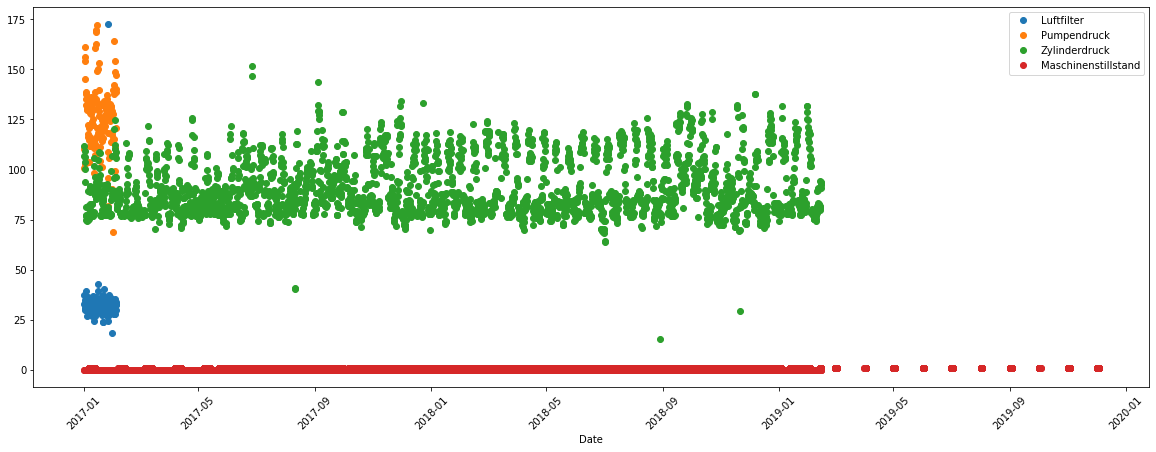

In [13]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


plt.figure(figsize=(20, 7))
plt.plot_date(x=data.DateTime,y=data.Luftfilter, label = 'Luftfilter')
plt.plot_date(x=data.DateTime,y=data.Pumpendruck, label = 'Pumpendruck')
plt.plot_date(x=data.DateTime,y=data.Zylinderdruck, label = 'Zylinderdruck')
plt.plot_date(x=data.DateTime,y=data.Maschinenstillstand,label = 'Maschinenstillstand')

plt.legend()
plt.xlabel('Date')
plt.xticks(rotation=45)

Plottet man die Messdaten, sieht man, dass die Werte des Luftfilters immer wieder schlagartig ansteigen. Wärend diesen Phasen, werden keine Werte für den Pumpendruck aufgezeichnet. Es könnte sich bei dem plötzlichen Anstieg um einen Zeitreiheneffekt handen, dann müsste man die Werte aller drei Messungen vor dem Anstieg für die Klassifizierung Maschinenstillstand ja/nein betrachtet werden. Maschienenstillstände kommen zu häufig vor -> Reduzierung des Datensatzes, Fokus auf einen bestimmten Zeitraum.

Wir fokusieren uns nur auf einenen bestimmten Zeitraum

In [14]:
data_na  = data[(data['DateTime'] < '2017-02-28-00:00:00.000')]

In [15]:
data_na.head()

,DateTime,Luftfilter,Pumpendruck,Zylinderdruck,Maschinenstillstand,Fehlercode
0,2017-01-01 00:00:00,37.500000,110.262204,111.784615,0.0,NaN
1,2017-01-01 06:00:00,33.090909,101.028021,106.850000,0.0,NaN
2,2017-01-01 12:00:00,33.250000,161.336352,109.462928,0.0,NaN
3,2017-01-01 18:00:00,29.892857,154.374667,103.761145,0.0,NaN
4,2017-01-02 00:00:00,34.800000,156.110791,106.111753,0.0,NaN


(array([736330., 736337., 736344., 736351., 736361., 736368., 736375.,
        736382., 736389.]), <a list of 9 Text xticklabel objects>)

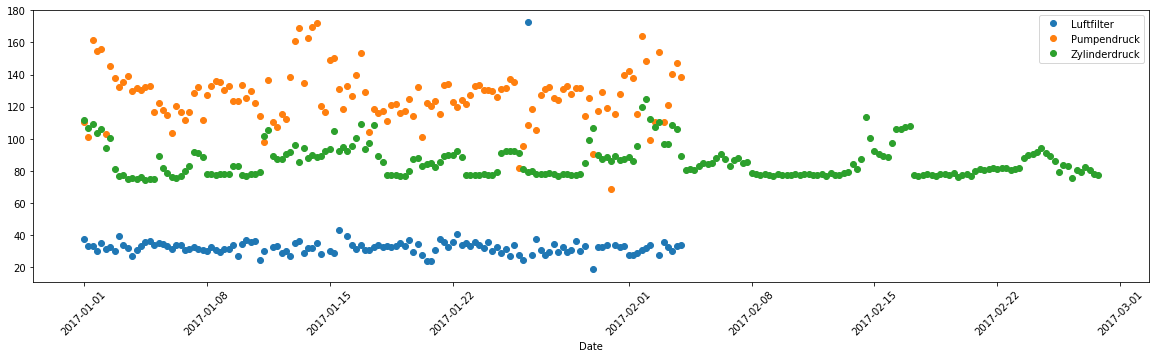

In [16]:
plt.figure(figsize=(20, 5))
plt.plot_date(x=data_na.DateTime,y=data_na.Luftfilter, label = 'Luftfilter')
plt.plot_date(x=data_na.DateTime,y=data_na.Pumpendruck,label = 'Pumpendruck')
plt.plot_date(x=data_na.DateTime,y=data_na.Zylinderdruck,label = 'Zylinderdruck')

plt.legend()
plt.xlabel('Date')
plt.xticks(rotation=45)




In der unteren Tabelle ist die häufigkeit der einzelnen Fehlercodes angezeigt. Da nicht bekannt ist, für welchen Fehler die jeweiligen Fehlercodes stehen, 

In [17]:
codes = data_na.groupby('Fehlercode').count().sort_values('DateTime').head(5)
data_na.groupby('Fehlercode').count().sort_values('DateTime')

,DateTime,Luftfilter,Pumpendruck,Zylinderdruck,Maschinenstillstand
Fehlercode,,,,,
901,1,0,0,0,1
850,1,0,0,0,1
685,1,0,0,0,1
663,1,0,0,0,1
539,2,0,0,0,2
682,2,0,0,0,2
668,2,0,0,0,2
531,3,0,0,0,3
534,3,0,0,0,3


In [18]:
graph_lines = pd.DataFrame(codes.index.values)
dates = []

for i in range(0,len(codes)):
    # = 
    #dates.append(data_na["DateTime"].loc[data_na['Fehlercode'] == int(graph_lines.loc[i])])
    dates.append(data_na["DateTime"].loc[data_na['Fehlercode'] == int(graph_lines.loc[i])].dt.to_pydatetime())

for i in range (0, len(dates)):
    dates[i] == pd.to_datetime(dates[i])
    

In [19]:
d = {'DateTime': dates, 'Code': codes.index.values}
df = pd.DataFrame(d)
codes = df.explode('DateTime')


In [20]:
codes.max()

DateTime    2017-02-07 19:34:24
Code                        901
dtype: object

(array([736330., 736337., 736344., 736351., 736361., 736368., 736375.,
        736382., 736389.]), <a list of 9 Text xticklabel objects>)

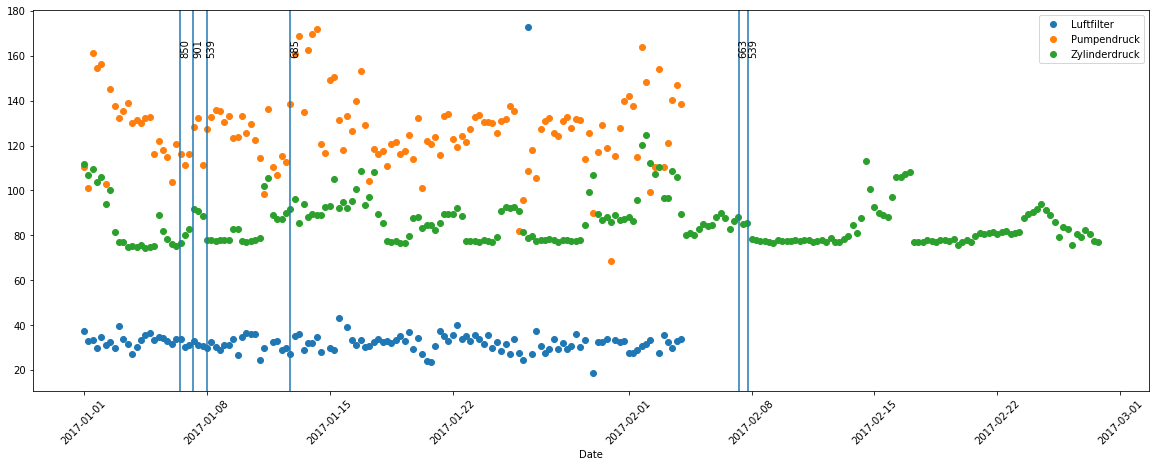

In [21]:
plt.figure(figsize=(20, 7))
plt.plot_date(x=data_na.DateTime,y=data_na.Luftfilter,label='Luftfilter')
plt.plot_date(x=data_na.DateTime,y=data_na.Pumpendruck,label ='Pumpendruck')
plt.plot_date(x=data_na.DateTime,y=data_na.Zylinderdruck,label = 'Zylinderdruck')

for i in range(0,len(codes)):
    
    plt.axvline(x= codes['DateTime'].iloc[i])
    plt.text(codes['DateTime'].iloc[i],160,codes['Code'].iloc[i],rotation=90)



plt.legend()
plt.xlabel('Date')
plt.xticks(rotation=45)


## Anomaly detection mit datastream

In [22]:
from dsio.main import restream_dataframe
from dsio.anomaly_detectors import Percentile1D

In [23]:
data_test = data_na.drop(['DateTime'], axis=1)

In [35]:
#restream_dataframe(data_test,Percentile1D)
#restream_dataframe(data_na,detector,sensors=['Luftfilter','Pumpendruck','Zylinderdruck'],speed=50,cols=2)

# Klassifizierung 0/1 Maschinenstillstand mit sklearn -> logistic regression

In [25]:
#NAs imputen mit Spalten-Mean
df = data_na.fillna(data_na.mean())

In [26]:
#DateTime konvertieren in Differenz in Stunden zum 1.Datum -> 2017-01-01 00:00:00
df['hours'] = (df['DateTime'] - df['DateTime'].min())/np.timedelta64(1, 'h')

In [27]:
#df zu predictos (X) und output variable (y)

data_model_X = df.drop(['Fehlercode','Maschinenstillstand','DateTime'], axis=1)
data_model_y = df['Maschinenstillstand']


In [28]:
#Test-train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_model_X, data_model_y, test_size=0.25, random_state=42)

In [29]:
#Train Model

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
# Prediction
predictions = logisticRegr.predict(X_test)

In [31]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.7793427230046949


Sehr schlechte Accuracy

In [32]:
#Rückführung in Date
prediction_graph_data = (X_test['hours']*np.timedelta64(1, 'h'))+df['DateTime'].min()

In [33]:
codes = data_na.groupby('Fehlercode').count().sort_values('DateTime')
graph_lines = pd.DataFrame(codes.index.values)
dates = []

for i in range(0,len(codes)):
    # = 
    #dates.append(data_na["DateTime"].loc[data_na['Fehlercode'] == int(graph_lines.loc[i])])
    dates.append(data_na["DateTime"].loc[data_na['Fehlercode'] == int(graph_lines.loc[i])].dt.to_pydatetime())

for i in range (0, len(dates)):
    dates[i] == pd.to_datetime(dates[i])
    
d = {'DateTime': dates, 'Code': codes.index.values}
df = pd.DataFrame(d)
codes = df.explode('DateTime')

(array([736330., 736337., 736344., 736351., 736361., 736368., 736375.,
        736382., 736389.]), <a list of 9 Text xticklabel objects>)

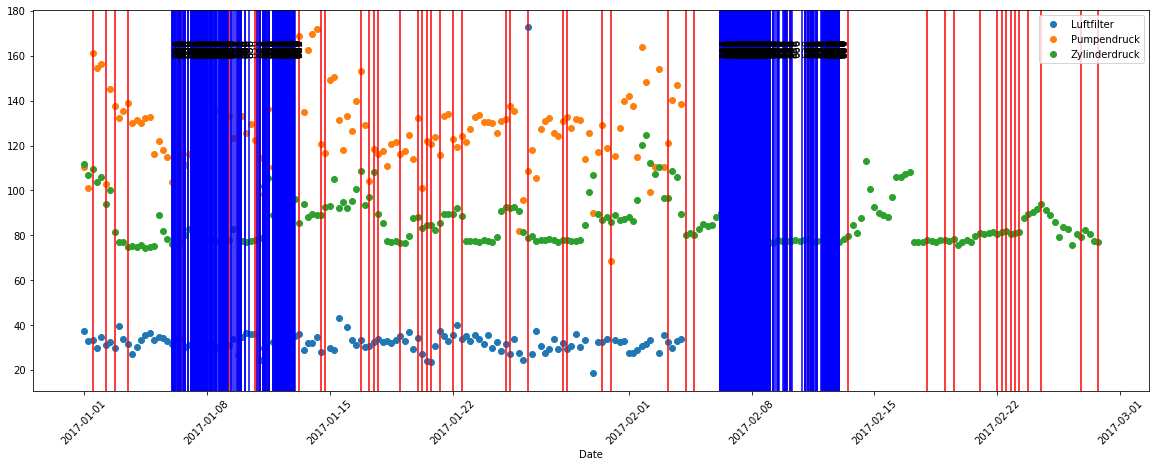

In [34]:

plt.figure(figsize=(20, 7))
plt.plot_date(x=data_na.DateTime,y=data_na.Luftfilter,label='Luftfilter')
plt.plot_date(x=data_na.DateTime,y=data_na.Pumpendruck,label ='Pumpendruck')
plt.plot_date(x=data_na.DateTime,y=data_na.Zylinderdruck,label = 'Zylinderdruck')

    

for i in range(0,len(prediction_graph_data)):
    plt.axvline(x= prediction_graph_data.iloc[i], c = 'red')
    
    
for i in range(0,len(codes)):
    
    plt.axvline(x= codes['DateTime'].iloc[i], c = 'blue')
    plt.text(codes['DateTime'].iloc[i],160,codes['Code'].iloc[i],rotation=90)


plt.legend()
plt.xlabel('Date')
plt.xticks(rotation=45)

Plot zeigt ware Maschinenstillstände (blau) vs vorhergesagte Maschinenstillstände (rot)